In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


 

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters for expanded dataset
n_samples = 10000  # Number of records
start_date = datetime(2015, 1, 1)
end_date = datetime(2024, 12, 31)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate random dates within the range
date_range = pd.date_range(start=start_date, end=end_date, periods=n_samples)

# Generate random business lines, event types, event counts, and loss amounts
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)
event_count_data = np.random.poisson(lam=5, size=n_samples)  # Poisson distribution for frequency
loss_amount_data = np.random.lognormal(mean=10, sigma=2, size=n_samples)  # Log-Normal for severity

# Create DataFrame
expanded_data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data
})

# Display the first few rows
expanded_data.head()


,Date,Business Line,Event Type,Event Count,Loss Amount
0,2015-01-01 00:00:00.000000000,Wealth Management,System Failure,8,65084.789719
1,2015-01-01 08:45:56.435643564,Retail Banking,System Failure,6,60066.658529
2,2015-01-01 17:31:52.871287128,Wealth Management,External Fraud,6,11274.210987
3,2015-01-02 02:17:49.306930693,Wealth Management,Fraud,3,6983.602908
4,2015-01-02 11:03:45.742574257,Retail Banking,System Failure,6,133403.773678


3. Perform Exploratory Data Analysis (EDA)
Descriptive Statistics

In [5]:
# Summary statistics
print("Summary Statistics:\n", expanded_data[['Event Count', 'Loss Amount']].describe())


Summary Statistics:
         Event Count   Loss Amount
count  10000.000000  1.000000e+04
mean       5.017900  1.443308e+05
std        2.245414  6.269918e+05
min        0.000000  6.046104e+00
25%        3.000000  5.623401e+03
50%        5.000000  2.156952e+04
75%        6.000000  8.566552e+04
max       14.000000  3.163245e+07


Distribution of Event Count and Loss Amount

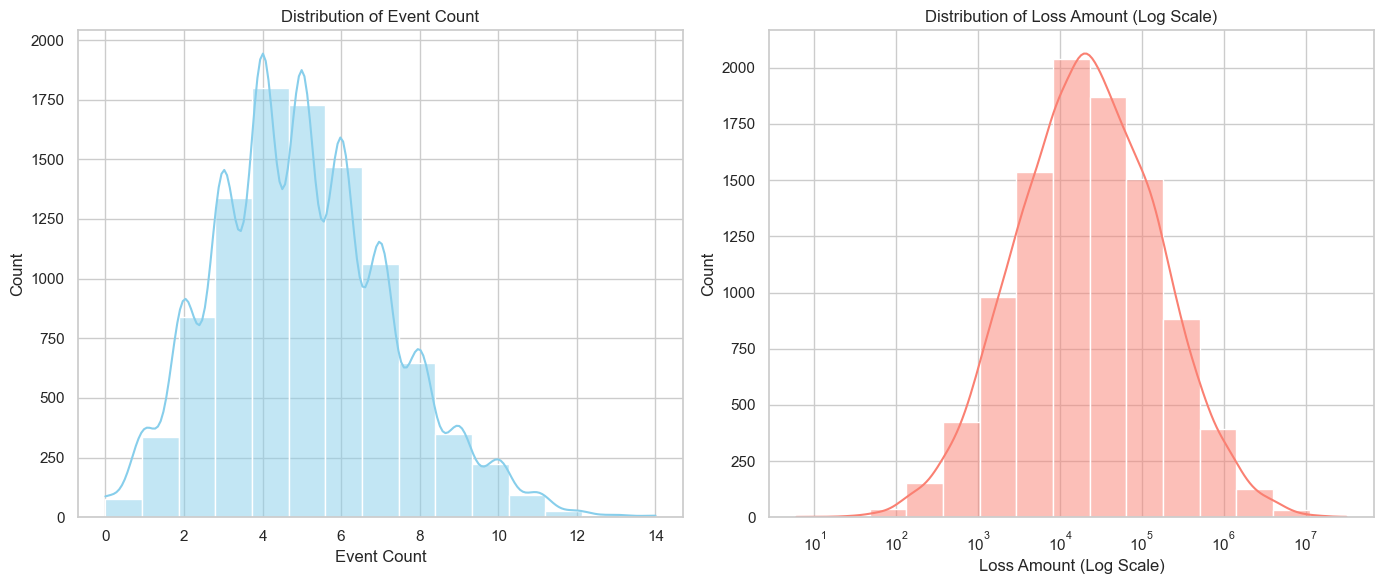

In [6]:
# Setting style
sns.set(style="whitegrid")

# Plot distributions
plt.figure(figsize=(14, 6))

# Event Count Distribution
plt.subplot(1, 2, 1)
sns.histplot(expanded_data['Event Count'], kde=True, bins=15, color='skyblue')
plt.title('Distribution of Event Count')
plt.xlabel('Event Count')

# Loss Amount Distribution (Log Scale)
plt.subplot(1, 2, 2)
sns.histplot(expanded_data['Loss Amount'], kde=True, bins=15, color='salmon', log_scale=True)
plt.title('Distribution of Loss Amount (Log Scale)')
plt.xlabel('Loss Amount (Log Scale)')

plt.tight_layout()
plt.show()


Monthly and Yearly Trends

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\2975345026.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  expanded_data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\2975345026.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  expanded_data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')


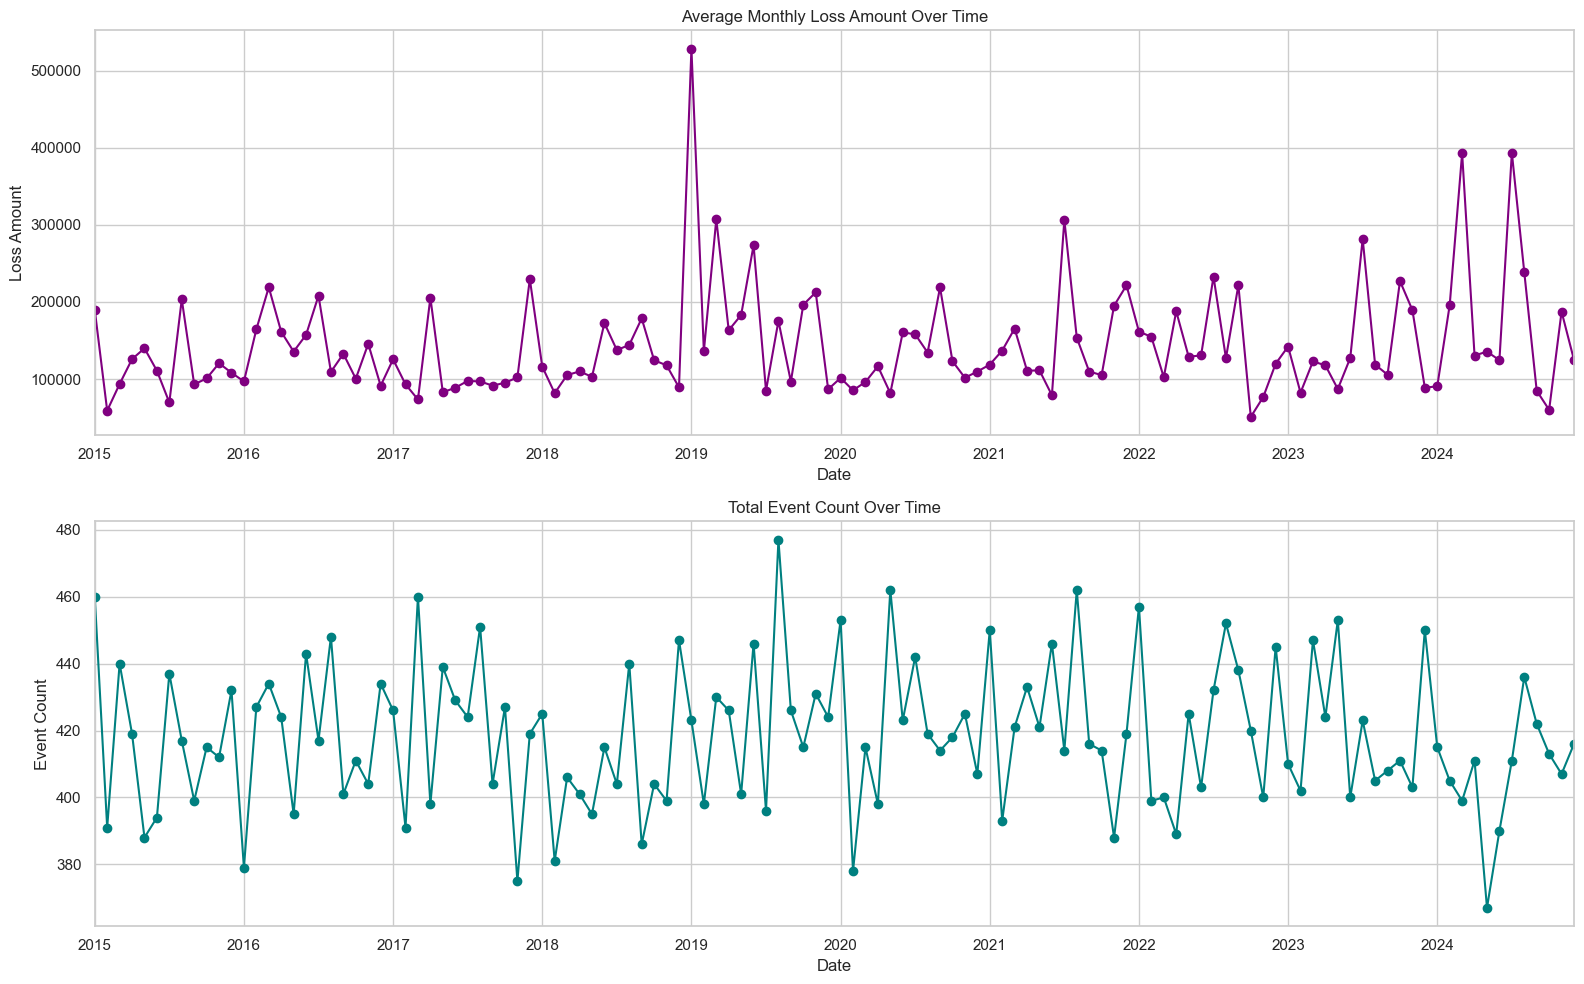

In [7]:
# Monthly Average Loss Amount
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
expanded_data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
plt.title('Average Monthly Loss Amount Over Time')
plt.ylabel('Loss Amount')

# Monthly Event Count Sum
plt.subplot(2, 1, 2)
expanded_data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')
plt.title('Total Event Count Over Time')
plt.ylabel('Event Count')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


Total Loss by Business Line and Event Type

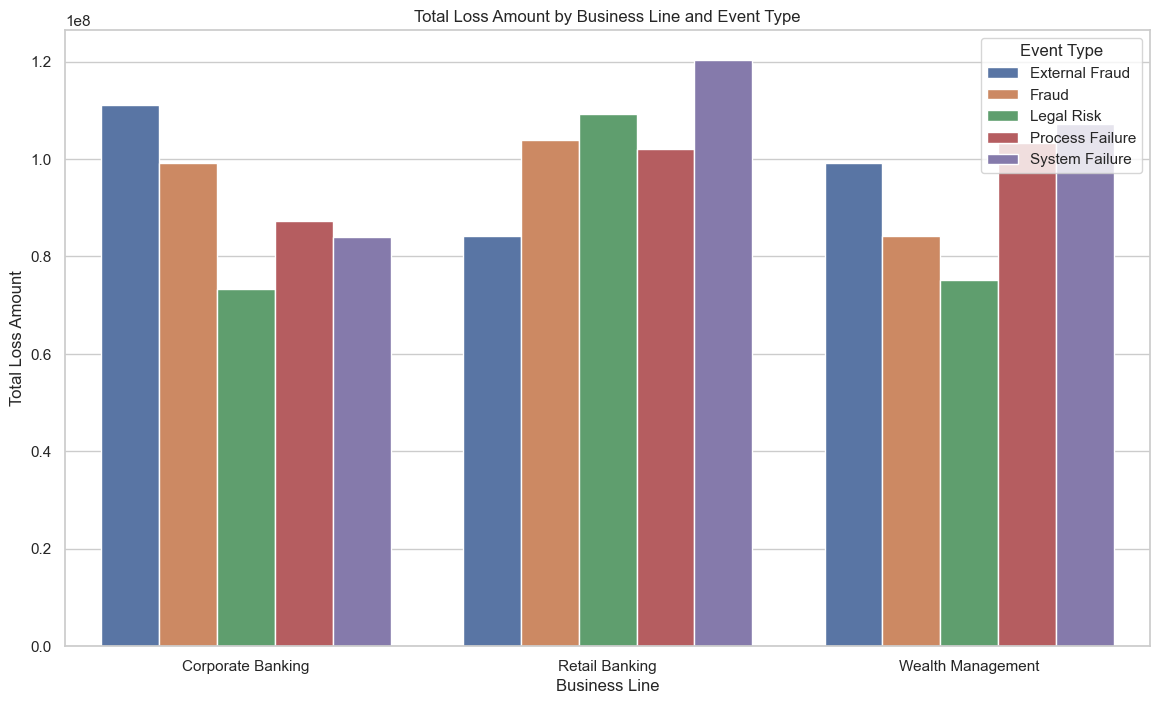

In [9]:
# Grouped by Business Line and Event Type
grouped_summary = expanded_data.groupby(['Business Line', 'Event Type']).agg({
    'Event Count': ['mean', 'sum'],
    'Loss Amount': ['mean', 'sum']
}).reset_index()

# Plot Total Loss Amount by Business Line and Event Type
plt.figure(figsize=(14, 8))
sns.barplot(data=grouped_summary, x='Business Line', y=('Loss Amount', 'sum'), hue='Event Type')
plt.title('Total Loss Amount by Business Line and Event Type')
plt.ylabel('Total Loss Amount')
# plt.yscale('log')  # Log scale due to skewness
plt.show()


4. Model the Loss Distribution Approach (LDA)
Below is a basic setup for modeling operational risk using a frequency (Poisson) and severity (Log-Normal) approach to estimate Value-at-Risk (VaR).

In [10]:
from scipy.stats import poisson, lognorm

# Parameters for Poisson (frequency) and Log-Normal (severity) based on data
frequency_lambda = expanded_data['Event Count'].mean()  # Average event frequency
severity_shape, severity_loc, severity_scale = lognorm.fit(expanded_data['Loss Amount'])  # Fit Log-Normal to loss amount

# Define a function to calculate VaR
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.99, n_simulations=10000):
    # Simulate event counts and loss amounts
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss distribution
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Calculate VaR at 99.9% confidence level
var_99_9 = calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999)
print(f"Value-at-Risk (99.9% confidence level): {var_99_9}")


Value-at-Risk (99.9% confidence level): 39964286.99883765


#severity
Here's a detailed example for an operational risk analysis using LDA in a Jupyter Notebook format. This example includes data generation, EDA, severity modeling, and calculating Value-at-Risk (VaR).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import poisson, lognorm


In [12]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters for dataset
n_samples = 10000
start_date = datetime(2015, 1, 1)
end_date = datetime(2024, 12, 31)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate random dates
date_range = pd.date_range(start=start_date, end=end_date, periods=n_samples)

# Generate other fields
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)
event_count_data = np.random.poisson(lam=5, size=n_samples)
loss_amount_data = np.random.lognormal(mean=10, sigma=2, size=n_samples)

# Create the DataFrame
data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data
})

# Display first few rows
data.head()


,Date,Business Line,Event Type,Event Count,Loss Amount
0,2015-01-01 00:00:00.000000000,Wealth Management,System Failure,8,65084.789719
1,2015-01-01 08:45:56.435643564,Retail Banking,System Failure,6,60066.658529
2,2015-01-01 17:31:52.871287128,Wealth Management,External Fraud,6,11274.210987
3,2015-01-02 02:17:49.306930693,Wealth Management,Fraud,3,6983.602908
4,2015-01-02 11:03:45.742574257,Retail Banking,System Failure,6,133403.773678


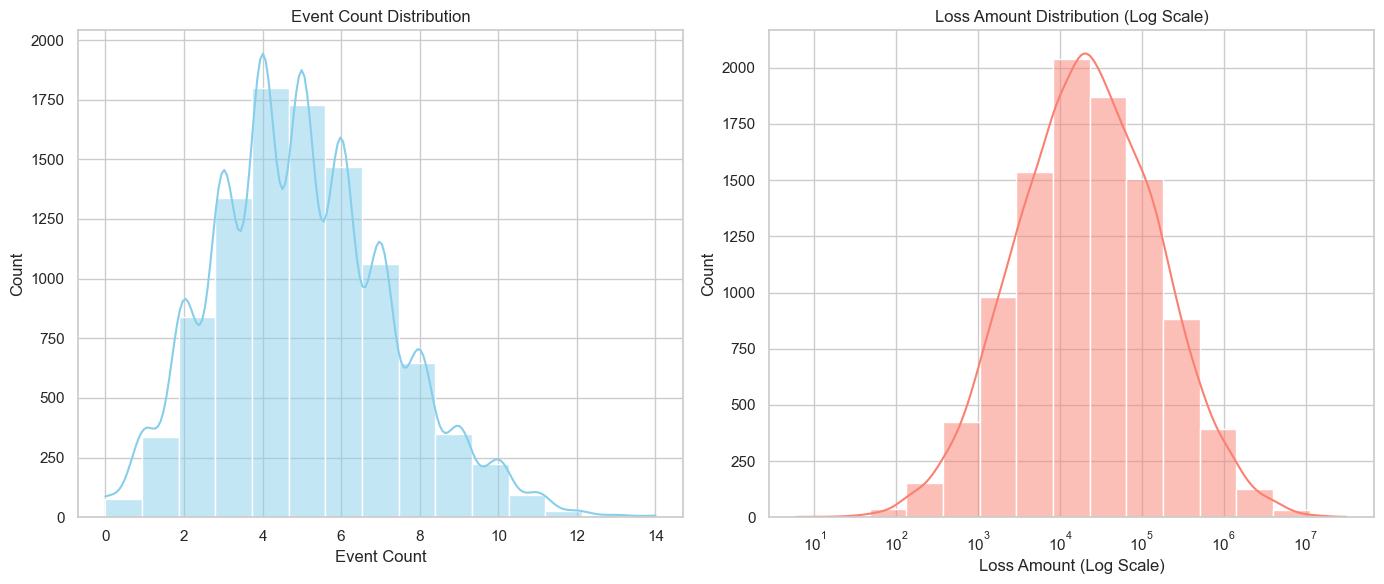

In [13]:
# Distribution plots
plt.figure(figsize=(14, 6))

# Event Count
plt.subplot(1, 2, 1)
sns.histplot(data['Event Count'], kde=True, bins=15, color='skyblue')
plt.title('Event Count Distribution')
plt.xlabel('Event Count')

# Loss Amount (Log Scale)
plt.subplot(1, 2, 2)
sns.histplot(data['Loss Amount'], kde=True, bins=15, color='salmon', log_scale=True)
plt.title('Loss Amount Distribution (Log Scale)')
plt.xlabel('Loss Amount (Log Scale)')

plt.tight_layout()
plt.show()


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\3612972231.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\3612972231.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')


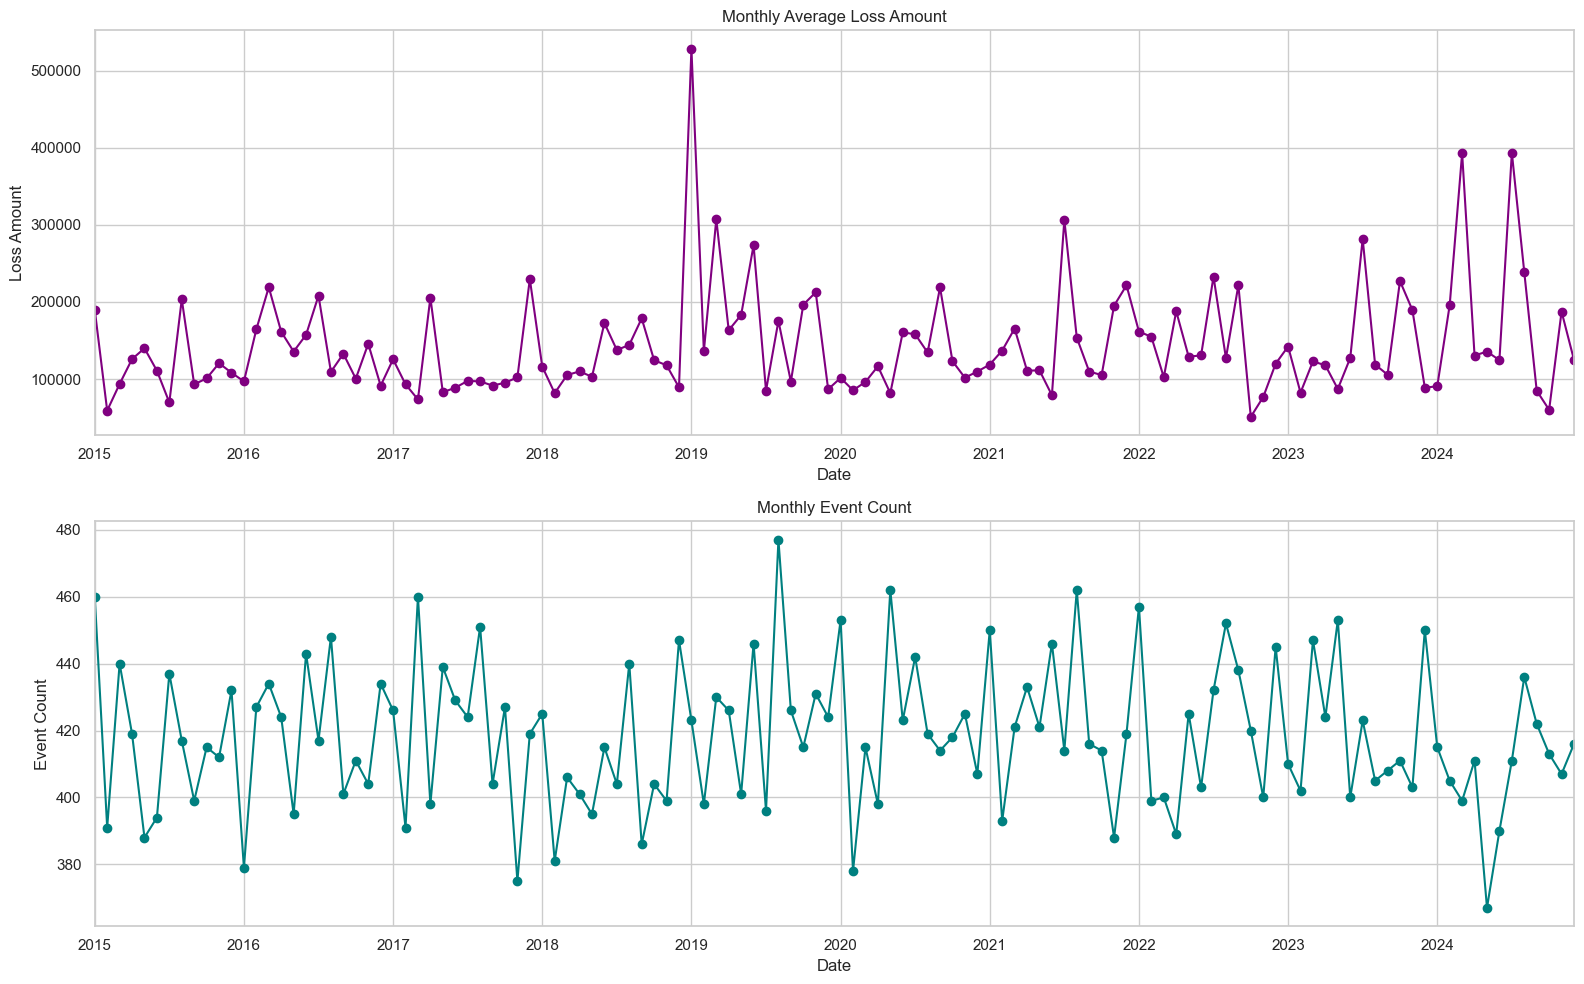

In [14]:
# Monthly average loss and event count
plt.figure(figsize=(16, 10))

# Monthly Loss Amount
plt.subplot(2, 1, 1)
data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
plt.title('Monthly Average Loss Amount')
plt.ylabel('Loss Amount')

# Monthly Event Count
plt.subplot(2, 1, 2)
data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')
plt.title('Monthly Event Count')
plt.ylabel('Event Count')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


Step 5: Total Loss by Business Line and Event Type

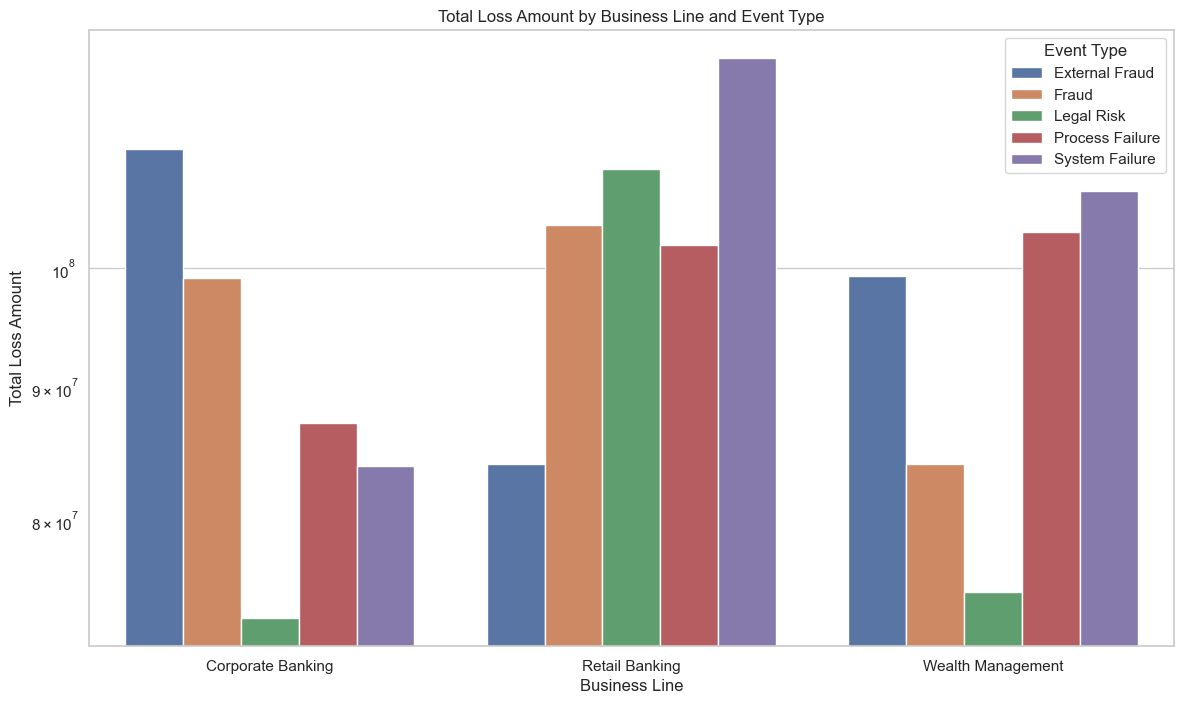

In [15]:
# Grouped analysis by Business Line and Event Type
grouped_data = data.groupby(['Business Line', 'Event Type']).agg({
    'Event Count': 'sum',
    'Loss Amount': 'sum'
}).reset_index()

# Bar plot for Loss Amount by Business Line and Event Type
plt.figure(figsize=(14, 8))
sns.barplot(data=grouped_data, x='Business Line', y='Loss Amount', hue='Event Type')
plt.title('Total Loss Amount by Business Line and Event Type')
plt.ylabel('Total Loss Amount')
plt.yscale('log')
plt.show()


Step 6: Modeling Severity and Frequency for LDA
Frequency: Modeled with a Poisson distribution (e.g., average Event Count).
Severity: Modeled with a Log-Normal distribution (e.g., distribution of Loss Amount).

In [16]:
# Fit Poisson distribution for frequency
frequency_lambda = data['Event Count'].mean()

# Fit Log-Normal distribution for severity (loss amount)
severity_shape, severity_loc, severity_scale = lognorm.fit(data['Loss Amount'])

print("Frequency (λ):", frequency_lambda)
print("Severity Parameters - Shape:", severity_shape, ", Location:", severity_loc, ", Scale:", severity_scale)


Frequency (λ): 5.0179
Severity Parameters - Shape: 1.9876142005603048 , Location: 0.3351335952553109 , Scale: 21732.42960281204


Step 7: Calculating Value-at-Risk (VaR) for Operational Risk
This function calculates the 99.9% VaR by simulating frequency and severity values and estimating the total loss.

In [17]:
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    # Simulate frequency of events
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity of losses
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss distribution
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Calculate VaR at 99.9% confidence level
var_99_9 = calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc)
print(f"Value-at-Risk (99.9% confidence level): {var_99_9}")


Value-at-Risk (99.9% confidence level): 39964286.99883765


Explanation of Severity and Frequency
In this example:

Frequency represents the number of times a risk event occurs within a time period, estimated by a Poisson distribution.
Severity represents the financial loss associated with each event, fitted to a Log-Normal distribution due to its heavy-tailed nature.
This notebook provides a full setup for operational risk analysis using LDA and calculating VaR. Let me know if you’d like further clarification on any section!

The output Value-at-Risk (VaR) at 99.9% confidence level: 39,964,287 means that, based on the model, there is a 99.9% probability that the total operational losses over the specified period will not exceed 39,964,287.

In other words, this VaR value indicates the potential maximum loss that the bank might face from operational risks (e.g., fraud, system failures) in a worst-case scenario within a 0.1% probability threshold. This helps the bank allocate sufficient capital to cover possible extreme losses and maintain financial stability.

For example, if this bank sets aside this amount as a reserve, it can be 99.9% confident that it will not incur operational losses higher than this amount in the given period.

Yes, the Value-at-Risk (VaR) at 99.9% confidence level of 39,964,287 in this model represents the combined risk across all business lines and all event types. This is because the VaR calculation here aggregates simulated losses based on the entire dataset, which includes multiple business lines (e.g., Retail Banking, Corporate Banking) and event types (e.g., Fraud, System Failure).

To get a more granular view, you could calculate VaR separately for each business line and event type. This approach can highlight which specific areas (business lines or event types) pose the highest risk and thus require more focused risk mitigation strategies or capital allocation.

To calculate the Value-at-Risk (VaR) at 99.9% confidence level for each business line and event type, we'll separate the dataset by each combination, then apply the same LDA methodology individually. Here’s the code to perform this breakdown.

Step 1: Import Required Libraries (if needed)

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm


Step 2: Define a Function to Calculate VaR
This function will allow us to calculate VaR given the frequency and severity parameters for each group.

In [19]:
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value


Step 3: Calculate VaR for Each Business Line and Event Type
This loop iterates over each combination of business line and event type, calculating VaR for each subset.

In [20]:
# Store results
var_results = []

# Loop over each business line and event type
for business_line in data['Business Line'].unique():
    for event_type in data['Event Type'].unique():
        # Filter the dataset for the current combination
        subset = data[(data['Business Line'] == business_line) & (data['Event Type'] == event_type)]
        
        # Calculate frequency and severity parameters for the subset
        frequency_lambda = subset['Event Count'].mean()
        severity_shape, severity_loc, severity_scale = lognorm.fit(subset['Loss Amount'])
        
        # Calculate VaR for the subset
        var_value = calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc)
        
        # Store the results
        var_results.append({
            'Business Line': business_line,
            'Event Type': event_type,
            'VaR_99.9%': var_value
        })

# Convert results to DataFrame for better readability
var_results_df = pd.DataFrame(var_results)

# Display results
var_results_df


,Business Line,Event Type,VaR_99.9%
0,Wealth Management,System Failure,6.787868e+07
1,Wealth Management,External Fraud,6.831331e+07
2,Wealth Management,Fraud,5.622282e+07
3,Wealth Management,Legal Risk,3.710092e+07
4,Wealth Management,Process Failure,5.635492e+07
5,Retail Banking,System Failure,4.218036e+07
6,Retail Banking,External Fraud,5.836477e+07
7,Retail Banking,Fraud,3.241883e+07
8,Retail Banking,Legal Risk,7.112447e+07
9,Retail Banking,Process Failure,6.297882e+07


Explanation of the Output
The resulting var_results_df DataFrame will contain the 99.9% VaR values calculated for each unique combination of business line and event type. For example:

This detailed breakdown helps identify which business line and event type combinations contribute most significantly to the total risk, allowing for more targeted risk management and capital allocation.

This detailed approach calculates the Value-at-Risk (VaR) at a 99.9% confidence level for each combination of business line and event type individually. By isolating each business line and event type, you gain a clear view of where the highest risks lie within your operational risk categories. Here’s a further breakdown of each part:

Detailed VaR Calculation by Subset:

Instead of calculating an aggregate VaR across all data, we filter the dataset by each business line (e.g., Retail Banking, Corporate Banking) and each event type (e.g., Fraud, System Failure).
For each subset, we calculate:
Frequency: Estimated using the average number of events for that subset.
Severity: Estimated by fitting a Log-Normal distribution to the subset’s loss amounts.
This gives us a tailored VaR for each specific combination, making it possible to identify which areas have the highest potential losses at the 99.9% confidence level.
Interpreting the Detailed Results:

The output table (var_results_df) provides a VaR value for each business line and event type combination.
For example:
If the "Fraud" category in "Corporate Banking" has a VaR of 8,923,000, it indicates that losses due to fraud in this line are not expected to exceed 8,923,000 with 99.9% confidence.
This allows you to pinpoint higher-risk areas, like specific event types within business lines, which may need more risk management or capital reserves.
Using the Detailed VaR Analysis:

Such detailed VaR breakdowns help banks allocate capital more effectively by focusing on higher-risk categories.
For example, if “Fraud” events in “Corporate Banking” have a high VaR, the bank might allocate more resources to fraud prevention in that business line or review internal controls.
This granular analysis is highly valuable in identifying specific risks within the organization, enabling focused and data-driven decisions on risk mitigation and capital allocation.

In [22]:
import pandas as pd
import numpy as np
from numpy.random import poisson, lognormal
from datetime import timedelta, datetime

# Parameters for data generation
n_samples = 1000  # Number of samples
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 10, 30)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate dates
date_range = pd.date_range(start_date, end_date, periods=n_samples)

# Generate business lines and event types
np.random.seed(0)
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)

# Generate event count using Poisson distribution
event_count_data = poisson(lam=5, size=n_samples)  # lambda=5 for moderate frequency

# Generate loss amounts using Log-Normal distribution
# Assume a realistic mu and sigma for Log-Normal to represent the loss severity
loss_amount_data = lognormal(mean=10, sigma=2, size=n_samples)  # high sigma for heavy-tail

# Construct the dataframe
dummy_data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data
})

dummy_data.head()


,Date,Business Line,Event Type,Event Count,Loss Amount
0,2023-01-01 00:00:00.000000000,Retail Banking,System Failure,8,77711.153667
1,2023-01-01 16:02:52.972972972,Corporate Banking,System Failure,7,52164.900954
2,2023-01-02 08:05:45.945945945,Retail Banking,System Failure,6,4026.244099
3,2023-01-03 00:08:38.918918918,Corporate Banking,Process Failure,4,62584.679211
4,2023-01-03 16:11:31.891891891,Corporate Banking,Process Failure,9,49474.487802


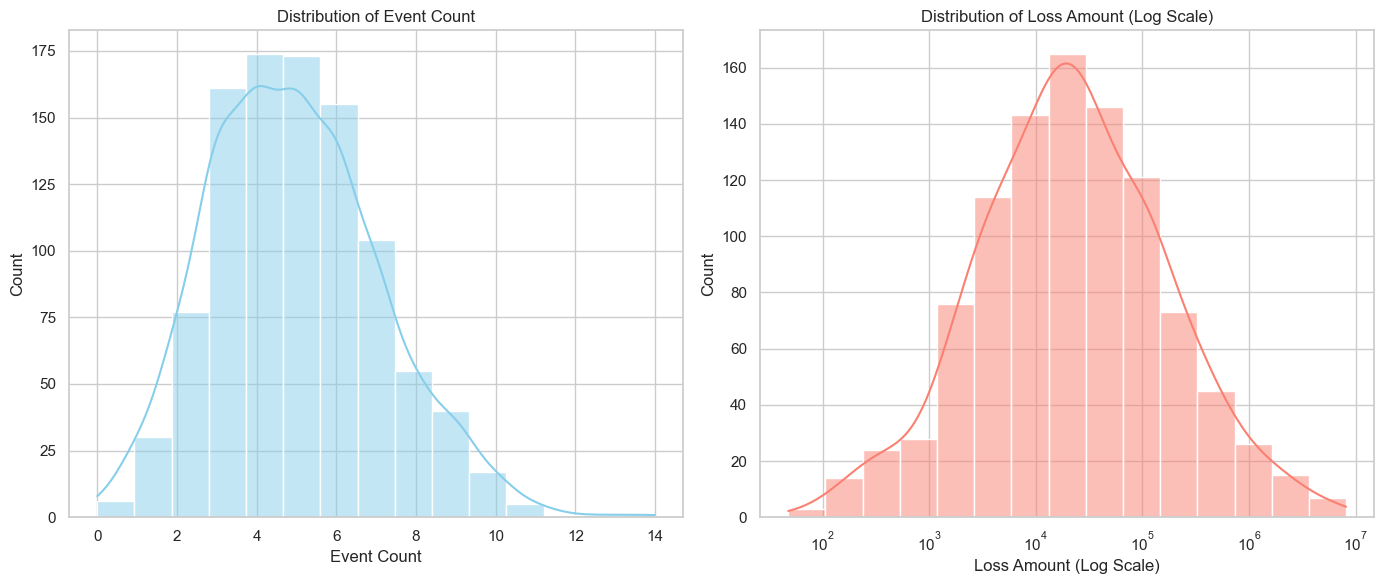

(       Event Count   Loss Amount
 count  1000.000000  1.000000e+03
 mean      4.950000  1.639773e+05
 std       2.155956  5.964058e+05
 min       0.000000  4.754071e+01
 25%       3.000000  5.559455e+03
 50%       5.000000  2.083475e+04
 75%       6.000000  8.769744e+04
 max      14.000000  8.144045e+06,
        Business Line       Event Type Event Count         Loss Amount  \
                                              mean  sum           mean   
 0  Corporate Banking   External Fraud    4.763158  362  124490.705294   
 1  Corporate Banking            Fraud    5.155172  299  228999.029853   
 2  Corporate Banking       Legal Risk    4.945455  272  156252.383028   
 3  Corporate Banking  Process Failure    5.086957  351   71850.089482   
 4  Corporate Banking   System Failure    5.000000  385  135628.917701   
 
                  
             sum  
 0  9.461294e+06  
 1  1.328194e+07  
 2  8.593881e+06  
 3  4.957656e+06  
 4  1.044343e+07  )

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up visual style
sns.set(style="whitegrid")

# Summary statistics for Event Count and Loss Amount
summary_stats = dummy_data[['Event Count', 'Loss Amount']].describe()

# Plotting Event Count distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(dummy_data['Event Count'], kde=True, bins=15, color='skyblue')
plt.title('Distribution of Event Count')
plt.xlabel('Event Count')

# Plotting Loss Amount distribution (Log Scale due to heavy-tailed nature)
plt.subplot(1, 2, 2)
sns.histplot(dummy_data['Loss Amount'], kde=True, bins=15, color='salmon', log_scale=True)
plt.title('Distribution of Loss Amount (Log Scale)')
plt.xlabel('Loss Amount (Log Scale)')

plt.tight_layout()
plt.show()

# Grouped summary statistics by Business Line and Event Type
grouped_summary = dummy_data.groupby(['Business Line', 'Event Type']).agg({
    'Event Count': ['mean', 'sum'],
    'Loss Amount': ['mean', 'sum']
}).reset_index()

summary_stats, grouped_summary.head()


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\2536990591.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dummy_data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\2536990591.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dummy_data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')


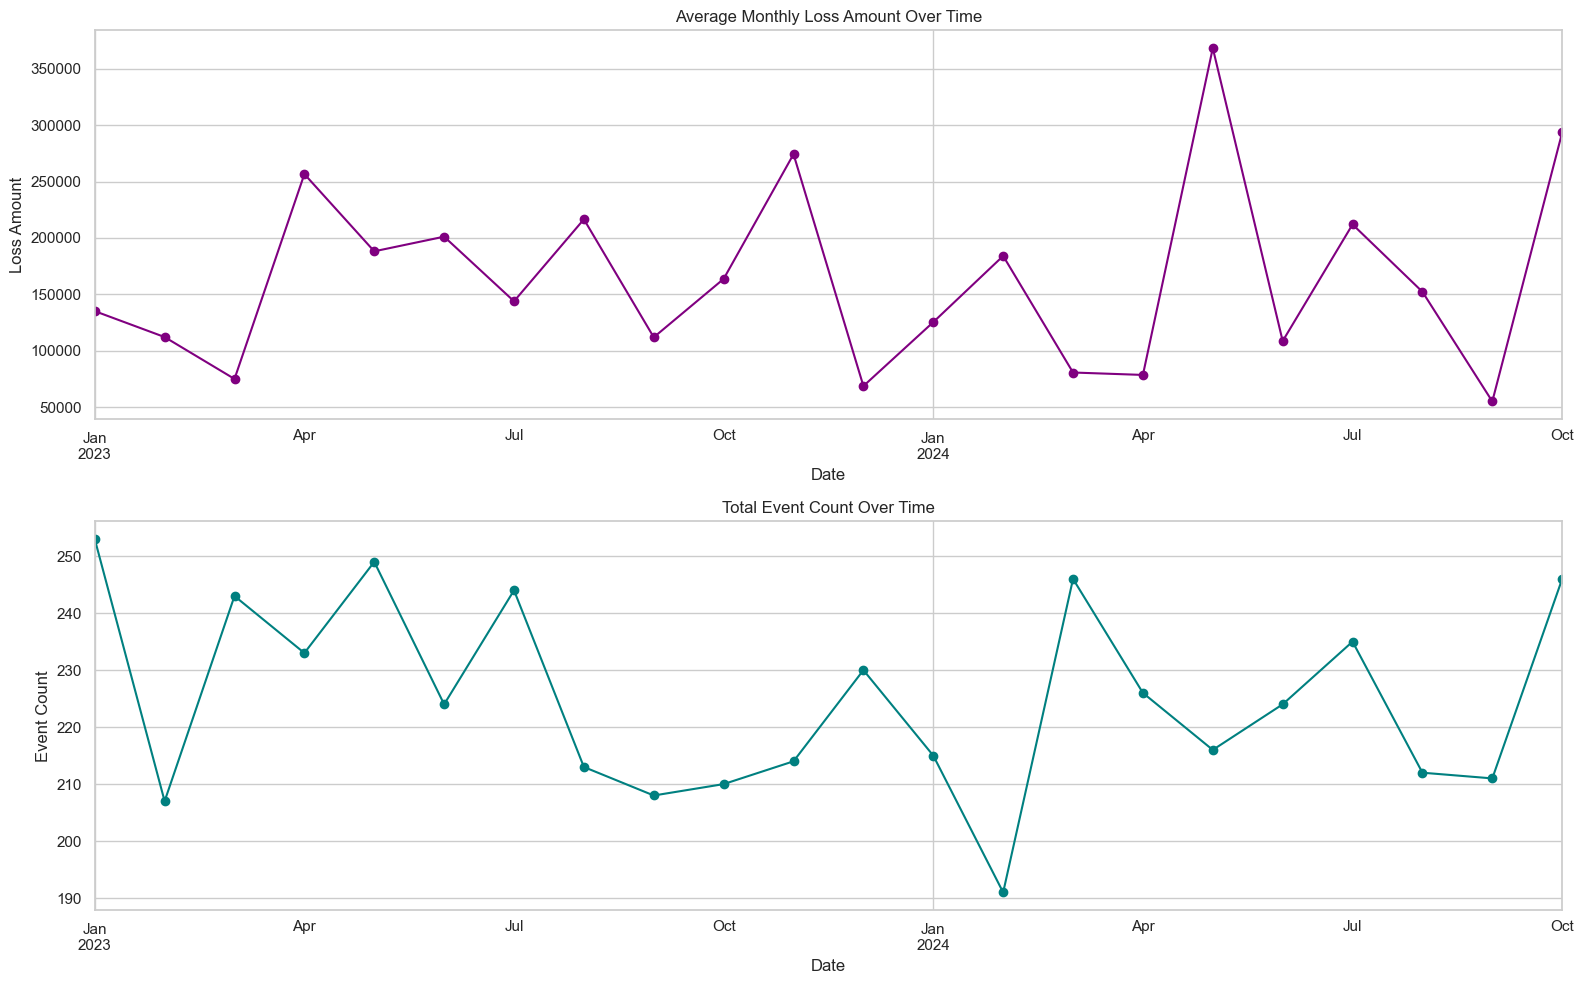

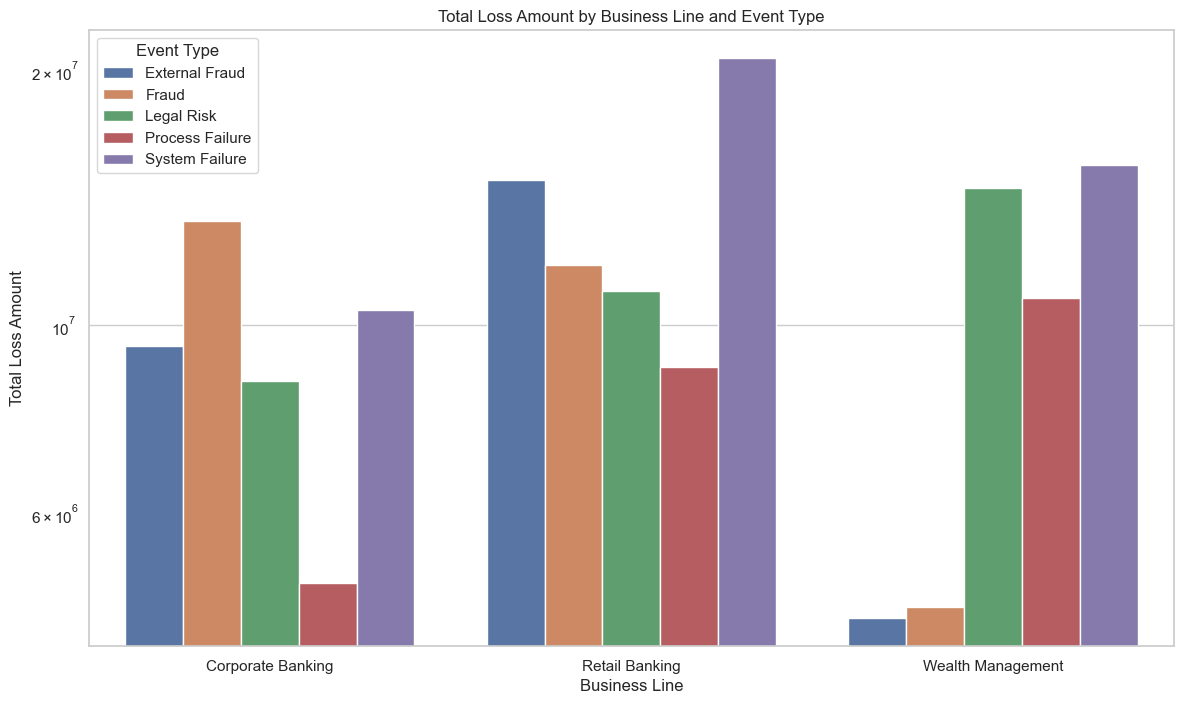

In [24]:
# Setting up plots for time-based analysis
plt.figure(figsize=(16, 10))

# Plotting average loss amount over time
plt.subplot(2, 1, 1)
dummy_data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
plt.title('Average Monthly Loss Amount Over Time')
plt.ylabel('Loss Amount')

# Plotting event frequency over time
plt.subplot(2, 1, 2)
dummy_data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')
plt.title('Total Event Count Over Time')
plt.ylabel('Event Count')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

# Visualizing total loss amount by business line and event type
plt.figure(figsize=(14, 8))
sns.barplot(data=grouped_summary, x='Business Line', y=('Loss Amount', 'sum'), hue='Event Type')
plt.title('Total Loss Amount by Business Line and Event Type')
plt.ylabel('Total Loss Amount')
plt.yscale('log')  # Log scale due to skewness
plt.show()
